## 🌍 Task 3: Cross-Country Solar Potential Comparison

Synthesize the cleaned datasets from Benin, Sierra Leone, and Togo to identify relative solar potential and key differences across countries.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

sns.set_style("whitegrid")

In [2]:
COUNTRIES = ['Benin', 'Sierra Leone', 'Togo']
FILE_PATHS = {
    'Benin': '../../data/benin/benin_clean.csv',
    'Sierra Leone': '../../data/sierra-leone/sierra_leone_clean.csv',
    'Togo': '../../data/togo/togo_clean.csv'
}
METRICS = ['GHI', 'DNI', 'DHI']

### 1. Load Data
Load each country’s cleaned CSV and combine into a single DataFrame.

In [3]:
all_data = []
print("Loading cleaned datasets...")

for country, path in FILE_PATHS.items():
    try:
        # Load the CSV
        df = pd.read_csv(path)
        # Add a 'Country' column for comparison
        df['Country'] = country
        all_data.append(df)
        print(f"✅ Loaded {country} with {len(df)} rows.")
    except FileNotFoundError:
        print(f"!!! ERROR: File not found for {country} at {path}. Using an empty placeholder.")
        # Create an empty DataFrame with required columns if file is missing to allow other countries to load
        df_empty = pd.DataFrame(columns=['Timestamp'] + METRICS + ['Country'])
        df_empty['Country'] = country
        all_data.append(df_empty)
    except Exception as e:
        print(f"!!! ERROR: Could not load data for {country}. {e}")

Loading cleaned datasets...
✅ Loaded Benin with 246878 rows.
✅ Loaded Sierra Leone with 238872 rows.
✅ Loaded Togo with 268215 rows.


Concatenate all DataFrames

In [4]:

df_combined = pd.concat(all_data, ignore_index=True)

if df_combined.empty:
    print("\n!!! All datasets failed to load. Cannot proceed with comparison.")
    # Exit or raise error if all data failed. For this script, we'll continue with an empty check.
else:
    print(f"\nTotal combined rows: {len(df_combined)}")

print("-" * 50)

df_combined.head()


Total combined rows: 753965
--------------------------------------------------


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Country
0,2021-08-09 06:54:00,16.7,0.0,16.5,16.1,16.3,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.2,23.7,Benin
1,2021-08-09 06:55:00,18.2,0.1,18.0,17.4,17.6,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.8,Benin
2,2021-08-09 06:56:00,19.7,0.3,19.5,18.7,18.9,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.9,Benin
3,2021-08-09 06:57:00,21.1,0.6,20.9,19.9,20.1,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.4,23.9,Benin
4,2021-08-09 06:58:00,22.5,1.1,22.2,21.1,21.3,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.5,24.0,Benin


### 2. Metric Comparison - Boxplots
Boxplots of GHI, DNI, DHI side-by-side (one plot per metric, colored by country).

Generating Boxplots for GHI, DNI, and DHI comparison...


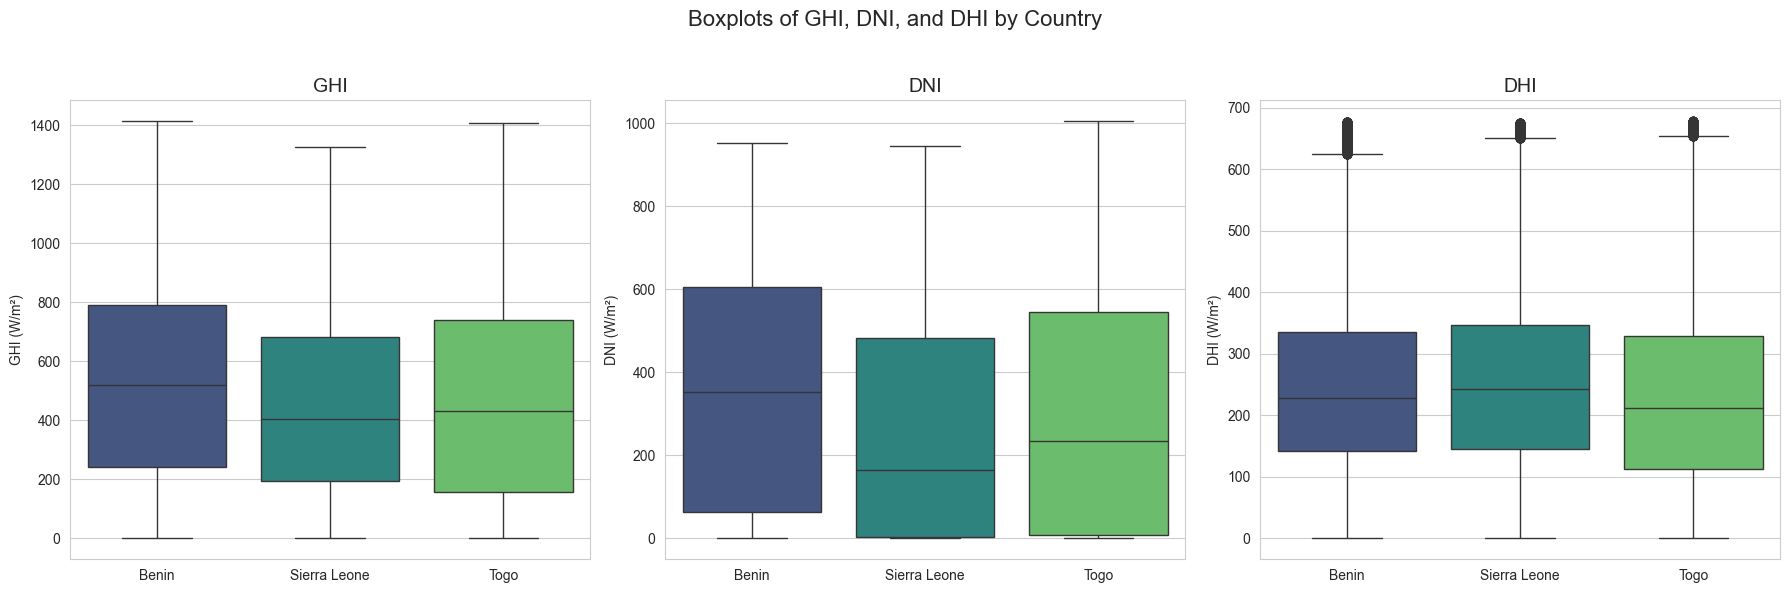

In [5]:
print("Generating Boxplots for GHI, DNI, and DHI comparison...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Boxplots of GHI, DNI, and DHI by Country', fontsize=16)

for i, metric in enumerate(METRICS):
    if metric in df_combined.columns:
        sns.boxplot(x='Country', y=metric, hue='Country', data=df_combined,
                    ax=axes[i], palette='viridis', legend=False)
        axes[i].set_title(metric, fontsize=14)
        axes[i].set_xlabel('')
        axes[i].set_ylabel(f'{metric} (W/m²)')
    else:
        axes[i].set_title(f'{metric} data not available', fontsize=14)
        axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### 3. Metric Comparison - Summary Table
Summary Table comparing mean, median, and standard deviation of GHI, DNI, and DHI across countries.

In [6]:
print("Generating Summary Table for GHI, DNI, and DHI...")

summary_table = (
    df_combined
    .groupby("Country")[["GHI", "DNI", "DHI"]]
    .agg(["mean", "median", "std"])
    .round(2)
)

display(summary_table)


Generating Summary Table for GHI, DNI, and DHI...


GHI                    DNI                    DHI         \
                mean median     std    mean median     std    mean median   
Country                                                                     
Benin         513.46  520.0  303.92  356.78  353.0  279.03  247.17  227.8   
Sierra Leone  443.92  404.8  292.17  255.40  165.7  262.25  250.75  242.2   
Togo          453.92  430.2  317.65  295.93  234.2  282.27  228.19  211.8   

                      
                 std  
Country               
Benin         142.61  
Sierra Leone  139.81  
Togo          149.15

### 4. Statistical Testing - One-Way ANOVA on GHI
Run a one-way ANOVA on GHI values to assess whether differences between countries are significant.

In [7]:
print("Running Statistical Tests on GHI across countries...")

# --- Prepare data grouped by country ---
groups = [group["GHI"].dropna().values for _, group in df_combined.groupby("Country")]

# --- One-way ANOVA ---
anova_stat, anova_p = stats.f_oneway(*groups)

# --- Kruskal–Wallis test (non-parametric alternative) ---
kruskal_stat, kruskal_p = stats.kruskal(*groups)

# --- Display results ---
print("\n--- Statistical Testing Results ---")
print(f"One-way ANOVA:    F-statistic = {anova_stat:.3f}, p-value = {anova_p:.5f}")
print(f"Kruskal–Wallis:   H-statistic = {kruskal_stat:.3f}, p-value = {kruskal_p:.5f}")

# --- Interpretation hint ---
if anova_p < 0.05 or kruskal_p < 0.05:
    print("\n→ The differences in GHI between countries are statistically significant (p < 0.05).")
else:
    print("\n→ No statistically significant differences found in GHI between countries (p ≥ 0.05).")


Running Statistical Tests on GHI across countries...

--- Statistical Testing Results ---
One-way ANOVA:    F-statistic = 3745.445, p-value = 0.00000
Kruskal–Wallis:   H-statistic = 7842.854, p-value = 0.00000

→ The differences in GHI between countries are statistically significant (p < 0.05).


### 5. Key Observations

* The ANOVA and Kruskal–Wallis tests both yielded p < 0.05, confirming that GHI differs significantly between countries.

* Benin shows the highest mean and median GHI (≈ 513 W/m²), suggesting stronger solar irradiance overall, though its standard deviation (≈ 304) indicates noticeable variability.

* Sierra Leone and Togo both have lower average GHI values, with Togo showing slightly higher median irradiance but also the greatest variability, suggesting more fluctuating solar conditions.

### 6. (Bonus) Visual Summary - Average GHI
A small bar chart ranking countries by average GHI.

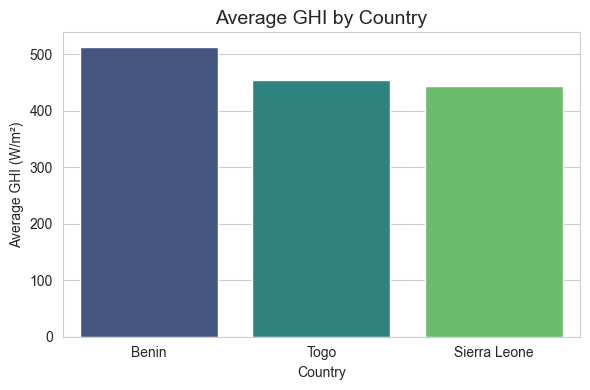

In [8]:
# Compute average GHI per country
ghi_avg = df_combined.groupby("Country")["GHI"].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(
    x=ghi_avg.index,
    y=ghi_avg.values,
    hue=ghi_avg.index,               # assign each bar a different hue
    palette="viridis",
    legend=False                     
)

plt.title("Average GHI by Country", fontsize=14)
plt.xlabel("Country")
plt.ylabel("Average GHI (W/m²)")
plt.tight_layout()
plt.show()

